## Imports

In [235]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from string import punctuation
import re
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
# from keras.utils.np_utils import probas_to_classes
from sklearn import preprocessing
from keras.models import Sequential
%matplotlib inline
from matplotlib import rcParams
from random import shuffle
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

## loading data

In [2]:
def load_data_from_xml(filename):
    aspect_data = {'Level0':[],'Level1':[]}
    sentences = list()
    tree = ET.parse(filename)
    root = tree.getroot()
    sentences = list()
    score= list()
    for row in root:
        sentences.append(row[2].text)
        temp = row[4].text.split('/')
        aspect_data['Level0'].append(temp[0])
        aspect_data['Level1'].append(temp[1])
    return aspect_data,sentences

In [3]:
aspect_data,sentences = load_data_from_xml('dataset/financial_posts_ABSA_train.xml')

In [4]:
print(len(sentences),len(aspect_data['Level0']),len(aspect_data['Level1']))

675 675 675


## insight into aspects 

In [5]:
aspect_data.keys()

dict_keys(['Level0', 'Level1'])

In [6]:
len(set(aspect_data['Level0']))

3

In [7]:
len(set(aspect_data['Level1']))

21

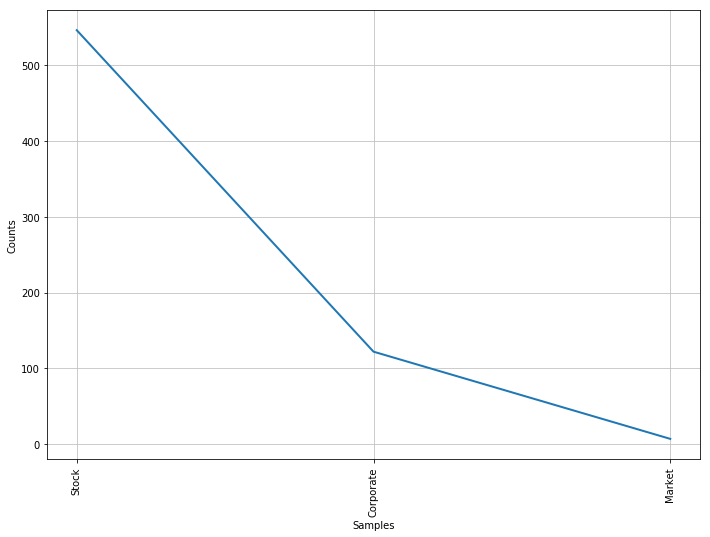

FreqDist({'Stock': 546, 'Corporate': 122, 'Market': 7})


In [8]:
level0_freq = FreqDist(aspect_data['Level0'])
level0_freq.plot()
level0_freq.pprint()

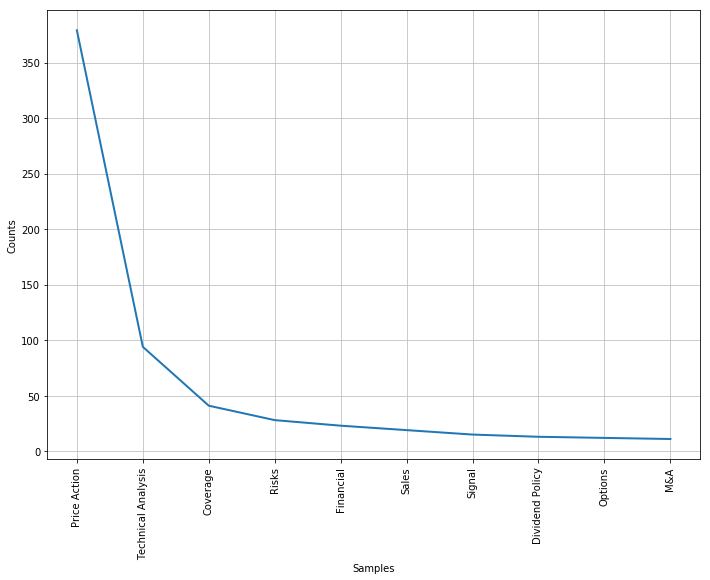

FreqDist({'Price Action': 379, 'Technical Analysis': 94, 'Coverage': 41, 'Risks': 28, 'Financial': 23, 'Sales': 19, 'Signal': 15, 'Dividend Policy': 13, 'Options': 12, 'M&A': 11, 'Strategy': 6, 'Rumors': 6, ...})


In [9]:
level1_freq = FreqDist(aspect_data['Level1'])
level1_freq.plot(10)
level1_freq.pprint(12)

In [178]:
def get_level_pairs(l1,l2):
    level_pair = dict()
    for pair in zip(l1,l2):
        if pair[1] in level_pair.keys():
            level_pair[pair[1]].append(pair[0])
        else:
            level_pair[pair[1]] = [pair[0]]
    for _ in level_pair.keys():
        level_pair[_] = list(set(level_pair[_]))
    return level_pair

In [179]:
L0_L1_pair = get_level_pairs(aspect_data['Level0'],aspect_data['Level1'])
L1_L0_pair = get_level_pairs(aspect_data['Level1'],aspect_data['Level0'])

In [180]:
L0_L1_pair

{'Conditions': ['Market'],
 'Coverage': ['Stock'],
 'Dividend Policy': ['Corporate'],
 'Financial': ['Corporate'],
 'Fundamentals': ['Stock'],
 'Insider Activity': ['Stock'],
 'Legal': ['Corporate'],
 'M&A': ['Corporate'],
 'Market': ['Market'],
 'Options': ['Stock'],
 'Price Action': ['Stock'],
 'Regulatory': ['Corporate'],
 'Reputation': ['Corporate'],
 'Risks': ['Corporate'],
 'Rumors': ['Corporate'],
 'Sales': ['Corporate'],
 'Signal': ['Stock'],
 'Stategy': ['Corporate'],
 'Strategy': ['Corporate'],
 'Technical Analysis': ['Stock', 'Corporate'],
 'Volatility': ['Market']}

In [181]:
L1_L0_pair

{'Corporate': ['Legal',
  'Reputation',
  'Risks',
  'Stategy',
  'M&A',
  'Rumors',
  'Regulatory',
  'Strategy',
  'Sales',
  'Financial',
  'Dividend Policy',
  'Technical Analysis'],
 'Market': ['Conditions', 'Volatility', 'Market'],
 'Stock': ['Options',
  'Price Action',
  'Insider Activity',
  'Fundamentals',
  'Coverage',
  'Technical Analysis',
  'Signal']}

In [135]:
C_Stock = 0
C_Corporate = 0
for pair in zip(aspect_data['Level0'],aspect_data['Level1']):
    if pair[1] == 'Technical Analysis':
        if pair[0] == 'Stock':
            C_Stock+=1
        else:
            C_Corporate+=1
print('C_Stock == ',C_Stock)
print('C_Corporate ==',C_Corporate)

C_Stock ==  92
C_Corporate == 2


## pre - processing data

In [15]:
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"(?:\@|https?\://)\S+", "", sentence)
    #removing stock names to see if it helps
    sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [16]:
sentences = [clean_sentence(x) for x in sentences]

In [17]:
# sentences

In [18]:
lengths = [len(s.split()) for s in sentences]

max len =  21


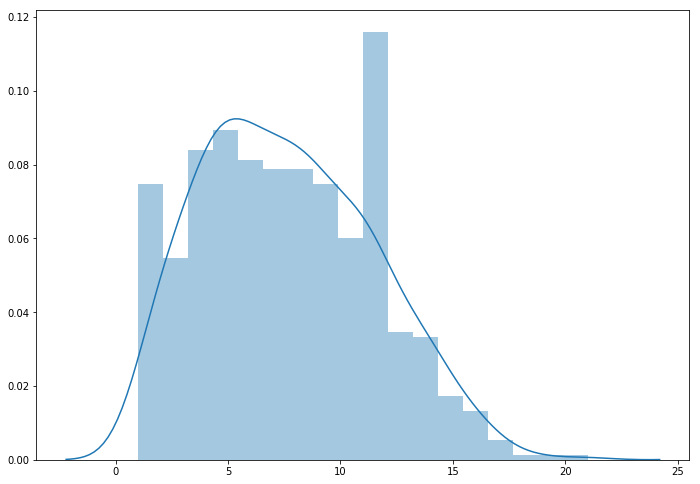

In [19]:
print('max len = ',max(lengths))
sns.distplot(lengths)

In [20]:
max_length  = 15

## Level 1 model

In [189]:
tranLines = sentences
trainLabels = aspect_data['Level1']

In [190]:
def shuffle_data(sentences,labels):
    numbers = [i for i in range(len(sentences))]
    shuffle(numbers)
    temp_text = []
    temp_labels = []
    for i in numbers:
        temp_text.append(sentences[i])
        temp_labels.append(labels[i])
    return temp_text,temp_labels

In [191]:
# tranLines,trainLabels = shuffle_data(tranLines,trainLabels)

In [192]:
no_of_classes = len(set(trainLabels))
no_of_classes

21

In [193]:
trainX,testX = tranLines[:int(len(tranLines)*0.9)],tranLines[int(len(tranLines)*0.9):]
trainY,testY = trainLabels[:int(len(trainLabels)*0.9)],trainLabels[int(len(trainLabels)*0.9):]

In [194]:
print(len(trainX),len(trainY))
print(len(testX),len(testY))

607 607
68 68


In [195]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [196]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [197]:
# create tokenizer
tokenizer = create_tokenizer(trainX)
# calculate max document length
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainX, max_length)
testX = encode_text(tokenizer, testX, max_length)
print(trainX.shape,testX.shape)

Max document length: 15
Vocabulary size: 2043
(607, 15) (68, 15)


In [198]:
# trainY

In [199]:
def convert_lables(trainY,testY):
    le = preprocessing.LabelEncoder()
    le.fit(trainY)
#     print(le.classes_)
    temp1 = le.transform(trainY)
    temp2 = le.transform(testY)
    return to_categorical(temp1,no_of_classes),to_categorical(temp2,no_of_classes),le.classes_

In [200]:
trainY,testY,lable_encoding = convert_lables(trainY,testY)

In [201]:
len(testY)

68

In [202]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [106]:
def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [107]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')
embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)

In [203]:
def defina_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 300,weights=[embedding_matrix_word2vec],input_length=max_length,trainable = False))
    model.add(Flatten())
    model.add(Dense(2000, activation='relu'))
    model.add(Dense(700, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(no_of_classes,activation='softmax'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # summarize the model
    print(model.summary())
    return model

In [204]:
model = defina_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 15, 300)           612900    
_________________________________________________________________
flatten_7 (Flatten)          (None, 4500)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 2000)              9002000   
_________________________________________________________________
dense_26 (Dense)             (None, 700)               1400700   
_________________________________________________________________
dense_27 (Dense)             (None, 200)               140200    
_________________________________________________________________
dense_28 (Dense)             (None, 21)                4221      
Total params: 11,160,021
Trainable params: 10,547,121
Non-trainable params: 612,900
__________________________________________________________

In [205]:
history_object = model.fit(trainX, trainY, epochs=20,batch_size=16)

Epoch 1/20
607/607 [==============================] - 7s 11ms/step - loss: 0.1181 - acc: 0.9618
Epoch 2/20
607/607 [==============================] - 5s 9ms/step - loss: 0.0488 - acc: 0.9849
Epoch 3/20
607/607 [==============================] - 6s 10ms/step - loss: 0.0202 - acc: 0.9937
Epoch 4/20
607/607 [==============================] - 6s 10ms/step - loss: 0.0085 - acc: 0.9974
Epoch 5/20
607/607 [==============================] - 6s 10ms/step - loss: 0.0023 - acc: 0.9993
Epoch 6/20
607/607 [==============================] - 6s 10ms/step - loss: 7.5831e-04 - acc: 0.9998
Epoch 7/20
607/607 [==============================] - 5s 9ms/step - loss: 0.0013 - acc: 0.9996
Epoch 8/20
607/607 [==============================] - 5s 9ms/step - loss: 0.0031 - acc: 0.9992
Epoch 9/20
607/607 [==============================] - 6s 9ms/step - loss: 0.0011 - acc: 0.9994
Epoch 10/20
607/607 [==============================] - 5s 9ms/step - loss: 0.0077 - acc: 0.9975
Epoch 11/20
607/607 [===================

In [230]:
model.evaluate(testX,testY)

68/68 [==============================] - 0s 1ms/step


[0.30413248258478504, 0.9684873819351196]

In [225]:
# model.evaluate(trainX,trainY)

607/607 [==============================] - 1s 887us/step


[6.6596945016589275e-06, 1.0]

In [245]:
pred = model.predict(testX)
for i in range(len(pred)):
    for j in range(len(pred[i])):
        if pred[i][j]>0.5:
            pred[i][j] = 1
        else:
            pred[i][j] = 0

In [249]:
for i in zip(pred,testY):
    if i[0].argmax()!=i[1].argmax():
        print(i[0].argmax(),i[1].argmax())

10 17
10 7
10 16
1 10
10 1
10 1
10 3
10 19
10 13
10 15
10 2
10 1
10 13
10 19
0 7
10 3
10 19
10 19
0 13
0 2
10 1
10 9
10 18
19 20


In [184]:
act_level1 = aspect_data['Level1'][int(len(trainLabels)*0.9):]
act_level0 = aspect_data['Level0'][int(len(trainLabels)*0.9):]
act_aspect= list()
for aspect in zip(act_level0,act_level1):
    act_aspect.append(aspect[0]+'/'+aspect[1])

In [188]:
count = 0
for i in zip(pred_aspect,act_aspect):
    if i[0]==i[1]:
        count+=1
    else:
        print(i)
print(count/len(act_aspect))

('Stock/Price Action', 'Corporate/Stategy')
('Stock/Price Action', 'Corporate/M&A')
('Stock/Price Action', 'Corporate/Risks')
('Stock/Signal', 'Stock/Technical Analysis')
('Stock/Price Action', 'Stock/Signal')
('Stock/Price Action', 'Stock/Coverage')
('Stock/Price Action', 'Stock/Coverage')
('Stock/Price Action', 'Corporate/Financial')
('Stock/Price Action', 'Stock/Technical Analysis')
('Stock/Price Action', 'Corporate/Risks')
('Stock/Technical Analysis', 'Stock/Price Action')
('Stock/Price Action', 'Corporate/Sales')
('Stock/Price Action', 'Stock/Technical Analysis')
('Stock/Price Action', 'Corporate/Dividend Policy')
('Stock/Price Action', 'Corporate/Risks')
('Stock/Price Action', 'Corporate/M&A')
('Stock/Price Action', 'Corporate/Financial')
('Stock/Price Action', 'Stock/Technical Analysis')
('Stock/Price Action', 'Stock/Technical Analysis')
('Stock/Price Action', 'Corporate/Risks')
('Stock/Technical Analysis', 'Stock/Price Action')
('Stock/Price Action', 'Stock/Coverage')
('Stock/T